Abgabe 2 Mark Nagengast Porro, Tim Schwabe

Aufgabe 1

In [435]:
import networkx as nx
import numpy as np
import matplotlib as plt

np.random.seed(10)

In [436]:
alpha = 0.1
pop_size = 20

In [437]:
def createGraph(n_nodes, n_edges):
    G = nx.Graph()
    G.add_nodes_from([i for i in range(0,n_nodes)])

    for n in range(n_edges):
        a = np.random.randint(n_nodes)
        while True:
            b = np.random.randint(n_nodes)
            if a != b:
                break
        G.add_edge(a,b)
    
    return G


G = createGraph(10,20)


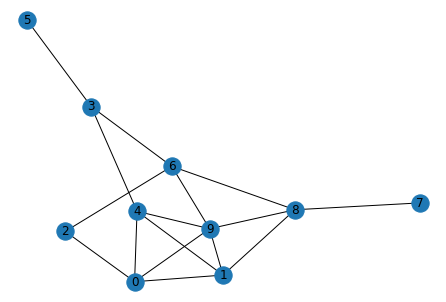

In [438]:
nx.draw(G, with_labels = True)

Aufgabe 2

In [439]:
def init_population(G):
    dic = dict()
    for i in range(0, pop_size):
        a = np.random.randint(G.number_of_nodes())
        while True:
            b = np.random.randint(G.number_of_nodes())
            if a != b:
                break
        dic.update([((a,b),0)])
    return dic

In [440]:
def fitness(population, G):
    fitness = 0

    for i in range(len(population.keys())):
        print(population.get(i))
    return fitness

Aufgabe 3

In [441]:
max( len(c) for c in nx.find_cliques(G))

4

In [442]:
population = init_population(G)
#print(population)
fitness(population,G)

TypeError: object of type 'builtin_function_or_method' has no len()